In [4]:
# https://www.kaggle.com/lct14558/imbalanced-data-why-you-should-not-use-roc-curve

In [5]:
import sys
import os
import math
from tqdm import tqdm
sys.path.append(os.path.join(os.path.expanduser('~'), 'projects'))
import j_utils.munging as mg
import seaborn as sns

from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve,roc_curve
from sklearn.linear_model import LogisticRegression

ppath = os.path.join(os.path.expanduser('~'), 'projects', 'lendingclub', )
dpath = os.path.join(ppath,'data')
pd.options.display.max_columns = 999

In [3]:
check_cols = ['maturity_time', 'maturity_paid', 'maturity_time_stat_adj', 'maturity_paid_stat_adj',
              'target_loose', 'target_strict', 'loan_status', 'issue_d', 'end_d', 'id']
good_statuses = ['paid', 'current']

In [4]:
eval_loan_info = pd.read_feather(os.path.join(dpath,'eval_loan_info.fth'))
# scaled_pmt_hist = pd.read_feather(os.path.join(dpath,'scaled_pmt_hist.fth'))
base_loan_info = pd.read_feather(os.path.join(dpath,'base_loan_info.fth'))
# str_loan_info = pd.read_feather(os.path.join(dpath,'str_loan_info.fth'))

# Exploration

## Get loans I can train/valid/test on

In [7]:
# get loans that are >= .95 maturity time, maturity paid, or status is in defaulted, charged_off, paid
trainable_loan_ids = eval_loan_info[(eval_loan_info['maturity_time_stat_adj'] >= .95) |
                               (eval_loan_info['maturity_paid_stat_adj'] >= .95) |
                               (eval_loan_info['loan_status'].isin(['paid', 'charged_off', 'defaulted']))
                              ]['id'].values

In [8]:
trainable_loans = eval_loan_info[eval_loan_info['id'].isin(trainable_loan_ids)]
untrainable_loans = eval_loan_info[~eval_loan_info['id'].isin(trainable_loan_ids)]

In [9]:
# make sure untrainable loans actually look untrainable
untrainable_loans.groupby('loan_status',).apply(lambda x: x.sample(min(len(x), 3)))

end_d    issue_d  maturity_paid  maturity_time  \
loan_status                                                               
current     1644785 2019-06-01 2017-10-01       0.527653       0.555556   
            719854  2019-06-01 2015-08-01       0.750054       0.766667   
            994378  2019-06-01 2016-03-01       0.632806       0.650000   
grace_15    1397183 2019-06-01 2017-03-01       0.694231       0.750000   
            1904474 2019-06-01 2018-04-01       0.332330       0.388889   
            2042774 2019-06-01 2018-07-01       0.146640       0.183333   
late_30     2181274 2019-06-01 2018-11-01       0.137158       0.194444   
            1581173 2019-06-01 2017-08-01       0.556044       0.611111   
            2274227 2019-06-01 2019-01-01       0.082720       0.138889   

                     maturity_time_stat_adj  maturity_paid_stat_adj  \
loan_status                                                           
current     1644785                0.555556                0.527653   
            719854                 0.766667                0.750054   
            994378                 0.650000                0.632806   
grace_15    1397183                0.837500                0.801250   
            1904474                0.602778                0.566015   
            2042774                0.469167                0.445316   
late_30     2181274                0.710000                0.689377   
            1581173                0.860000                0.840176   
            2274227                0.690000                0.669779   

                     rem_to_be_paid  roi_simple  target_loose  target_strict  \
loan_status                                                                    
current     1644785     7167.254883    0.571889             0              0   
            719854      6374.397949    1.062707             0              0   
            994378      8303.632812    1.046442             0              0   
grace_15    1397183     3018.048584    0.856539             0              1   
            1904474    20670.951172    0.428704             0              1   
            2042774    18583.417969    0.236544             0              1   
late_30     2181274    27465.431641    0.199358             0              1   
            1581173     4977.800293    0.623456             0              1   
            2274227     7949.898438    0.102417             0              1   

                    loan_status         id grade  int_rate  term      0.05  \
loan_status                                                                  
current     1644785     current  119718006     A    0.0532    36 -0.450976   
            719854      current   58260752     C    0.1465    60 -0.031962   
            994378      current   74645906     E    0.2197    60 -0.031799   
grace_15    1397183    grace_15  100162511     C    0.1399    36 -0.186970   
            1904474    grace_15  131702907     D    0.1747    36 -0.546796   
            2042774    grace_15  137364801     D    0.2089    60 -0.767258   
late_30     2181274     late_30  142812794     E    0.2631    36 -0.800223   
            1581173     late_30  115374427     A    0.0735    36 -0.403433   
            2274227     late_30  145907649     C    0.1447    36 -0.897633   

                         0.06      0.07      0.08      0.09       0.1  \
loan_status                                                             
current     1644785 -0.455450 -0.459872 -0.464244 -0.468566 -0.472838   
            719854  -0.049628 -0.066849 -0.083638 -0.100008 -0.115970   
            994378  -0.046900 -0.061676 -0.076135 -0.090285 -0.104133   
grace_15    1397183 -0.195585 -0.204073 -0.212436 -0.220676 -0.228795   
            1904474 -0.549396 -0.551975 -0.554533 -0.557069 -0.559585   
            2042774 -0.768233 -0.769202 -0.770164 -0.771121 -0.772073   
late_30     2181274 -0.800718 -0.801211 -0.801703 -0.802192 -0.802679   
            1581173 

In [10]:
trainable_eli = trainable_loans
trainable_li = base_loan_info[base_loan_info['id'].isin(trainable_loan_ids)]
print(trainable_eli.shape, trainable_li.shape)

(1473189, 46) (1473189, 103)


In [11]:
df = trainable_li.merge(trainable_eli[['target_strict', 'id']], on='id')

## split into time_series_cv splits

In [12]:
# # get categorical feature indices for catboost
# obj_cols = df.select_dtypes(['object', 'datetime']).columns
# categorical_features_indices = [df.columns.get_loc(col) for col in obj_cols]
# obj_cols

## preprocess for scikit

In [14]:
# map dates and strings to numbers
non_num_cols = df.select_dtypes(['datetime', 'object']).columns
for col in non_num_cols:
    mapper = {np.NaN: 0}
    for i, val in enumerate(sorted(df[col].unique()), 1):
        mapper[val] = i
    df[col] = df[col].replace(mapper)
    if col == 'issue_d':
        issue_d_mapper = mapper

# for scikit, make sure everything is number and nulls are filled
non_num_cols = df.select_dtypes(['object', 'datetime']).columns
assert len(non_num_cols) == 0
df.fillna(-9999, inplace=True)

In [15]:
# # split out the test set, say the last 12 months
# test = df[df['issue_d'] >= (df['issue_d'].max() - 12)]
# train = df[df['issue_d'] < (df['issue_d'].max() - 12)]
test_ids = eval_loan_info[eval_loan_info['issue_d'] >= (eval_loan_info['issue_d'].max() + pd.DateOffset(months=-12))]['id'].values
test = df.query('id in @test_ids')
train = df.query('id not in @test_ids')

In [16]:
print(test.shape)
test.head()

(69868, 104)


,total_il_high_credit_limit,initial_list_status,inq_last_12m,tax_liens,fico_range_low,sec_app_num_rev_accts,avg_cur_bal,open_act_il,total_bal_ex_mort,application_type,pct_tl_nvr_dlq,sec_app_chargeoff_within_12_mths,sec_app_inq_last_6_mths,id,is_inc_v,num_actv_rev_tl,mort_acc,num_il_tl,percent_bc_gt_75,collections_12_mths_ex_med,revol_bal_joint,total_bal_il,open_il_12m,sec_app_mths_since_last_major_derog,installment,num_op_rev_tl,pub_rec,annual_inc,open_rv_12m,tot_coll_amt,sec_app_revol_util,sec_app_earliest_cr_line,emp_length,term,mths_since_last_major_derog,max_bal_bc,tot_cur_bal,delinq_amnt,sec_app_collections_12_mths_ex_med,chargeoff_within_12_mths,all_util,total_acc,revol_util,mths_since_recent_revol_delinq,dti,open_acc,inq_fi,mo_sin_rcnt_tl,int_rate,mths_since_last_record,total_bc_limit,num_actv_bc_tl,addr_zip,num_bc_sats,dti_joint,open_il_24m,earliest_cr_line,delinq_2_yrs,num_tl_op_past_12m,pub_rec_bankruptcies,num_tl_90g_dpd_24m,mths_since_last_delinq,inq_last_6_mths,tot_hi_cred_lim,num_sats,mo_sin_old_il_acct,num_bc_tl,fico_range_high,bc_open_to_buy,num_accts_ever_12_0_ppd,total_rev_hi_lim,open_rv_24m,annual_inc_joint,is_inc_v_joint,i_l_util,num_rev_tl_bal_gt_0,num_tl_12_0dpd_2m,mths_since_rcnt_il,sec_app_fico_range_low,sec_app_mort_acc,num_rev_accts,acc_open_past_24_mths,home_ownership,grade,mths_since_recent_bc_dlq,sec_app_fico_range_high,num_tl_30dpd,loan_amount,total_cu_tl,purpose,acc_now_delinq,mo_sin_old_rev_tl_op,open_acc_6m,funded_amount,addr_state,revol_bal,mo_sin_rcnt_rev_tl_op,sec_app_open_acc,mths_since_recent_bc,sec_app_open_act_il,bc_util,sub_grade,mths_since_recent_inq,target_strict
935737,66132.0,2,3.0,0.0,705.0,-9999.0,11717.0,2.0,68148.0,1,1.0,-9999.0,-9999.0,74617043,1,4.0,1.0,9.0,0.250,0.0,-9999.0,55010.0,3.0,-9999.0,197.999451,12.0,0.0,70000.0,2.0,0.0,-9999.0,1,4,36,-9999.0,7123.0,175755.0,0.0,-9999.0,0.0,0.54,22.0,0.326,-9999.0,0.2189,15.0,4.0,2.0,0.1155,-9999.0,31600.0,3.0,738,8.0,-9999.0,5.0,585,0.0,5.0,0.0,0.0,-9999.0,1.0,252460.0,15.0,67.0,8.0,709.0,18566.0,0.0,40300.0,6.0,-9999.0,1,0.97,4.0,0.0,3.0,-9999.0,-9999.0,12.0,11.0,4,2,-9999.0,-9999.0,0.0,6000.0,1.0,2,0.0,49.0,3.0,6000.0,44,13138.0,2.0,-9999.0,2.0,-9999.0,0.412,9,4.0,1
1226126,5322.0,2,4.0,0.0,705.0,-9999.0,5256.0,1.0,3685.0,1,1.0,-9999.0,-9999.0,100065804,1,7.0,2.0,10.0,0.000,0.0,-9999.0,739.0,1.0,-9999.0,193.377441,14.0,0.0,32000.0,3.0,1703.0,-9999.0,1,12,36,-9999.0,383.0,78837.0,0.0,-9999.0,0.0,0.15,29.0,0.156,-9999.0,0.1669,16.0,1.0,4.0,0.0992,-9999.0,9500.0,2.0,372,4.0,-9999.0,2.0,631,0.0,5.0,0.0,0.0,-9999.0,1.0,99822.0,16.0,123.0,7.0,709.0,9111.0,0.0,18900.0,5.0,-9999.0,1,0.14,7.0,0.0,12.0,-9999.0,-9999.0,17.0,8.0,1,2,-9999.0,-9999.0,0.0,6000.0,0.0,3,0.0,139.0,2.0,6000.0,43,2946.0,4.0,-9999.0,8.0,-9999.0,0.041,7,4.0,1
1351636,43055.0,2,1.0,2.0,710.0,-9999.0,16643.0,3.0,39318.0,1,1.0,-9999.0,-9999.0,121324916,3,9.0,2.0,6.0,0.111,0.0,-9999.0,12502.0,0.0,-9999.0,1220.624390,12.0,2.0,181000.0,2.0,0.0,-9999.0,1,2,36,-9999.0,6545.0,266281.0,0.0,-9999.0,0.0,0.34,21.0,0.368,-9999.0,0.1425,16.0,0.0,7.0,0.0796,12.0,67700.0,8.0,567,9.0,-9999.0,1.0,478,0.0,2.0,0.0,0.0,-9999.0,1.0,359463.0,16.0,89.0,9.0,714.0,42705.0,0.0,72900.0,4.0,-9999.0,1,0.29,9.0,0.0,24.0,-9999.0,-9999.0,13.0,5.0,1,1,-9999.0,-9999.0,0.0,38975.0,4.0,3,0.0,292.0,0.0,38975.0,27,26816.0,7.0,-9999.0,7.0,-9999.0,0.369,5,5.0,0
1362135,46096.0,1,1.0,0.0,695.0,-9999.0,6848.0,6.0,61634.0,1,1.0,-9999.0,-9999.0,123056681,1,3.0,1.0,20.0,0.333,0.0,-9999.0,38933.0,1.0,-9999.0,484.114136,3.0,0.0,45000.0,1.0,0.0,-9999.0,1,4,36,-9999.0,15113.0,61634.0,0.0,-9999.0,0.0,0.64,24.0,0.445,-9999.0,0.2363,9.0,1.0,4.0,0.0734,-9999.0,51000.0,3.0,670,3.0,-9999.0,3.0,656,0.0,2.0,0.0,0.0,-9999.0,0.0,97096.0,9.0,115.0,3.0,699.0,28299.0,0.0,51000.0,1.0,-9999.0,1,0.85,3.0,0.0,8.0,-9999.0,-9999.0,3.0,5.0,1,1,-9999.0,-9999.0,0.0,15600.0,0.0,3,0.0,106.0,1.0,15600.0,19,22701.0,4.0,-9999.0,4.0,-9999.0,0.445,4,8.0,0
1381982,0.0,2,0.0,0.0,730.0,-9999.0,1371.0,0.0,10964.0,1,1.0,-9999.0,-9999.0,126108153,1,6.0,

In [17]:
print(train.shape)
train.head()

(1403321, 104)


,total_il_high_credit_limit,initial_list_status,inq_last_12m,tax_liens,fico_range_low,sec_app_num_rev_accts,avg_cur_bal,open_act_il,total_bal_ex_mort,application_type,pct_tl_nvr_dlq,sec_app_chargeoff_within_12_mths,sec_app_inq_last_6_mths,id,is_inc_v,num_actv_rev_tl,mort_acc,num_il_tl,percent_bc_gt_75,collections_12_mths_ex_med,revol_bal_joint,total_bal_il,open_il_12m,sec_app_mths_since_last_major_derog,installment,num_op_rev_tl,pub_rec,annual_inc,open_rv_12m,tot_coll_amt,sec_app_revol_util,sec_app_earliest_cr_line,emp_length,term,mths_since_last_major_derog,max_bal_bc,tot_cur_bal,delinq_amnt,sec_app_collections_12_mths_ex_med,chargeoff_within_12_mths,all_util,total_acc,revol_util,mths_since_recent_revol_delinq,dti,open_acc,inq_fi,mo_sin_rcnt_tl,int_rate,mths_since_last_record,total_bc_limit,num_actv_bc_tl,addr_zip,num_bc_sats,dti_joint,open_il_24m,earliest_cr_line,delinq_2_yrs,num_tl_op_past_12m,pub_rec_bankruptcies,num_tl_90g_dpd_24m,mths_since_last_delinq,inq_last_6_mths,tot_hi_cred_lim,num_sats,mo_sin_old_il_acct,num_bc_tl,fico_range_high,bc_open_to_buy,num_accts_ever_12_0_ppd,total_rev_hi_lim,open_rv_24m,annual_inc_joint,is_inc_v_joint,i_l_util,num_rev_tl_bal_gt_0,num_tl_12_0dpd_2m,mths_since_rcnt_il,sec_app_fico_range_low,sec_app_mort_acc,num_rev_accts,acc_open_past_24_mths,home_ownership,grade,mths_since_recent_bc_dlq,sec_app_fico_range_high,num_tl_30dpd,loan_amount,total_cu_tl,purpose,acc_now_delinq,mo_sin_old_rev_tl_op,open_acc_6m,funded_amount,addr_state,revol_bal,mo_sin_rcnt_rev_tl_op,sec_app_open_acc,mths_since_recent_bc,sec_app_open_act_il,bc_util,sub_grade,mths_since_recent_inq,target_strict
0,-9999.0,1,-9999.0,0.0,735.0,-9999.0,-9999.0,-9999.0,-9999.0,1,-9999.00,-9999.0,-9999.0,54734,2,-9999.0,-9999.0,-9999.0,-9999.000,0.0,-9999.0,-9999.0,-9999.0,-9999.0,829.046021,-9999.0,0.0,85000.0,-9999.0,-9999.0,-9999.0,1,11,36,-9999.0,-9999.0,-9999.0,0.0,-9999.0,0.0,-9999.00,42.0,0.521,-9999.0,0.1948,10.0,-9999.0,-9999.0,0.1189,-9999.0,-9999.0,-9999.0,891,-9999.0,-9999.0,-9999.0,481,0.0,-9999.0,0.0,-9999.0,-9999.0,0.0,-9999.0,-9999.0,-9999.0,-9999.0,739.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,1,-9999.00,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,4,2,-9999.0,-9999.0,-9999.0,25000.0,-9999.0,3,0.0,-9999.0,-9999.0,25000.0,5,28854.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.000,9,-9999.0,0
1,-9999.0,1,-9999.0,0.0,640.0,-9999.0,-9999.0,-9999.0,-9999.0,1,-9999.00,-9999.0,-9999.0,55521,1,-9999.0,-9999.0,-9999.0,-9999.000,0.0,-9999.0,-9999.0,-9999.0,-9999.0,35.196629,-9999.0,0.0,30000.0,-9999.0,-9999.0,-9999.0,1,11,36,-9999.0,-9999.0,-9999.0,0.0,-9999.0,0.0,-9999.00,15.0,0.904,-9999.0,0.2384,9.0,-9999.0,-9999.0,0.1608,-9999.0,-9999.0,-9999.0,573,-9999.0,-9999.0,-9999.0,571,0.0,-9999.0,0.0,-9999.0,-9999.0,1.0,-9999.0,-9999.0,-9999.0,-9999.0,644.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,1,-9999.00,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,4,6,-9999.0,-9999.0,-9999.0,1000.0,-9999.0,3,0.0,-9999.0,-9999.0,1000.0,15,10125.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.000,27,-9999.0,0
2,5929.0,2,6.0,0.0,665.0,-9999.0,596.0,1.0,8351.0,1,0.69,-9999.0,-9999.0,55716,1,13.0,0.0,11.0,0.857,0.0,-9999.0,502.0,0.0,-9999.0,139.140762,13.0,1.0,30784.0,4.0,0.0,-9999.0,1,11,36,31.0,1158.0,8351.0,0.0,-9999.0,0.0,0.74,36.0,0.740,-9999.0,0.1696,14.0,2.0,7.0,0.2499,28.0,6350.0,7.0,934,14.0,-9999.0,0.0,591,0.0,4.0,1.0,0.0,-9999.0,4.0,16579.0,14.0,160.0,17.0,669.0,907.0,1.0,10650.0,13.0,-9999.0,1,0.08,13.0,-9999.0,50.0,-9999.0,-9999.0,25.0,13.0,4,5,-9999.0,-9999.0,0.0,3500.0,4.0,3,0.0,127.0,0.0,3500.0,48,7849.0,7.0,-9999.0,7.0,-9999.0,0.790,24,2.0,0
3,-9999.0,1,-9999.0,0.0,705.0,-9999.0,-9999.0,-9999.0,-9999.0,1,-9999.00,-9999.0,-9999.0,55742,1,-9999.0,-9999.0,-9999.0,-9999.000,0.0,-9999.0,-9999.0,-9999.0,-9999.0,228.211746,-9999.0,0.0,65000.0,-9999.0,-9999.0,-9999.0,1,11,36,-9999.0,-9999.0,-9999.0,0.0,-9999.0,0.0,-9999.00,7.0,0.767,-9999.0,0.1429,7.0,-9999.0,-9999.0,0.1071,-9999.0,-9999.0,-9999.0,104,-9999.0,-9999.0,-9999.0,561,0.0,-9999

In [18]:
# see if theres any difference in pct defaulted from train and test
print(test['target_strict'].sum()/len(test), train['target_strict'].sum()/len(train))

# a slightly higher percentage of defaulting loans. This makes sense due to defaulting loans finishing faster, thus being able to be included in trainable loans, compared to ongoing loans that won't default but still need to reach term

0.24991412377626382 0.2300314753360065


## train with time series splits (verify that with each split, old loans can be used to train a model to pick new loans)

In [19]:
# basic split for now, probably some leakage (using some loans issued in same month for train and validation. Go with this for now, come back and make better custom splits later)
from sklearn.model_selection import TimeSeriesSplit

In [20]:
def setup_datasets(train_index, test_index, train, test):
    y = train['target_strict']
    train.drop('target_strict', axis=1)
    X = train

    X_train = X.iloc[train_index,:]
    y_train = y.iloc[train_index]

    X_valid = X.iloc[test_index,:]
    y_valid = y.iloc[test_index]

    y_test = test['target_strict']
    test.drop('target_strict', axis=1)
    X_test = test
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test

def PlotConfusionMatrix(y_test,pred,y_test_legit,y_test_fraud):

    cfn_matrix = confusion_matrix(y_test,pred)
    cfn_norm_matrix = np.array([[1.0 / y_test_legit,1.0/y_test_legit],[1.0/y_test_fraud,1.0/y_test_fraud]])
    norm_cfn_matrix = cfn_matrix * cfn_norm_matrix

    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,2,1)
    sns.heatmap(cfn_matrix,cmap='coolwarm_r',linewidths=1,annot=True,ax=ax)
    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')

    ax = fig.add_subplot(1,2,2)
    sns.heatmap(norm_cfn_matrix,cmap='coolwarm_r',linewidths=1,annot=True,ax=ax)

    plt.title('Normalized Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.tight_layout()
    plt.show()
    
def show_classification(y_test, pred):    
    print('---Classification Report---')
    print(classification_report(y_test,pred))

In [21]:
tscv = TimeSeriesSplit(n_splits=5)

/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


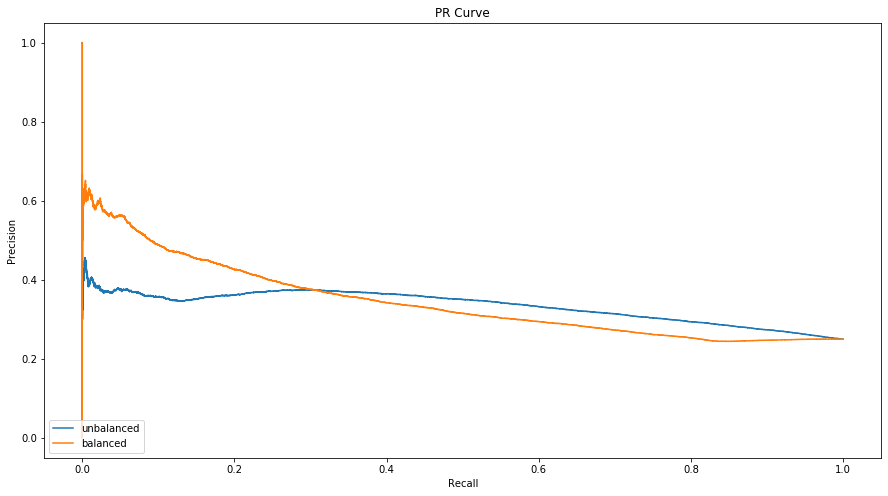

/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


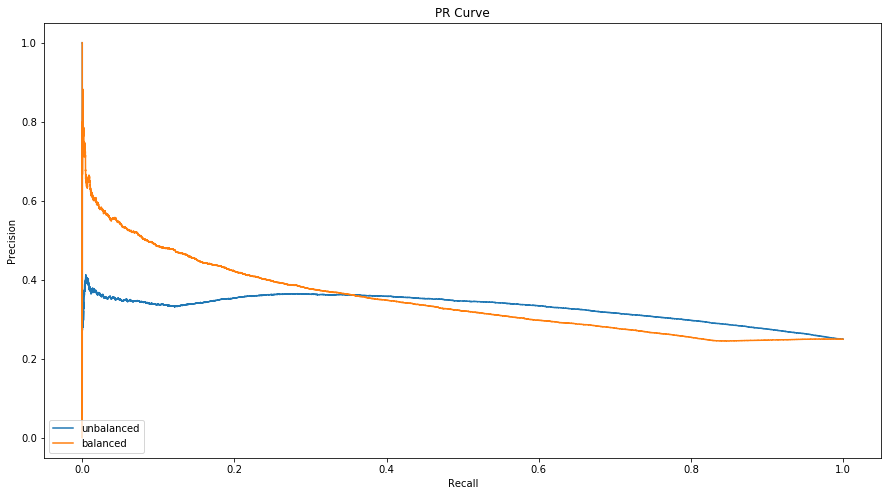

/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


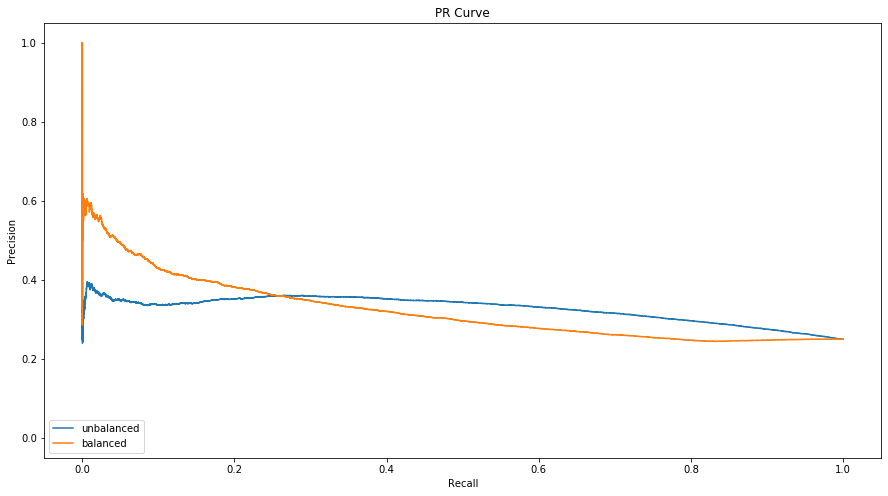

/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


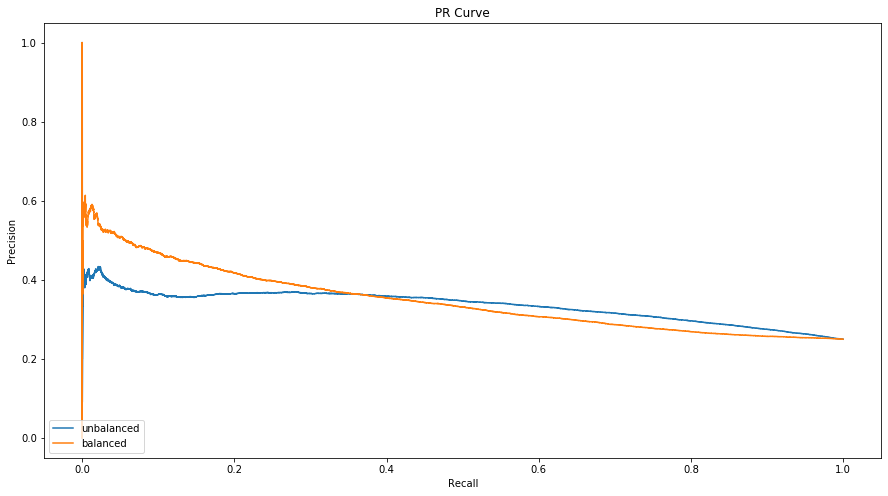

/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


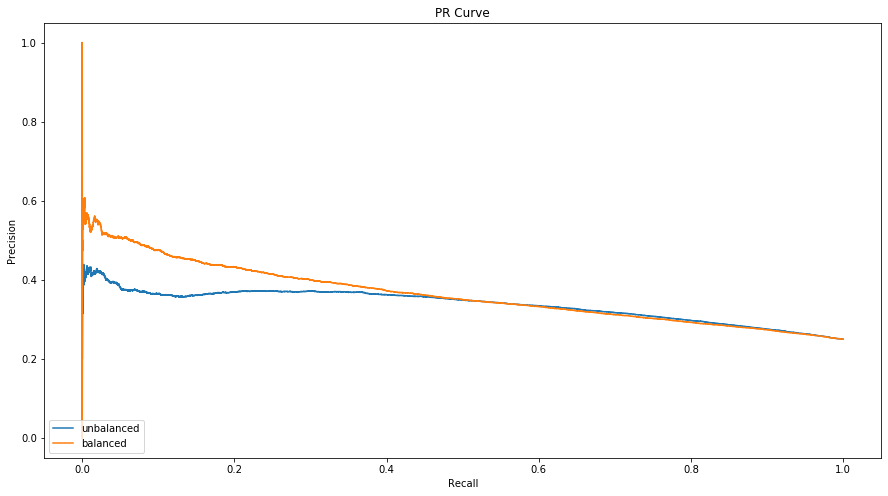

In [22]:
p_r_prob_dict = {}
for i, indicies in enumerate(tscv.split(train)):
    train_index, test_index = indicies
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_valid, X_test, y_train, y_valid, y_test = setup_datasets(train_index, test_index, train, test)
    y_test_non_def, y_test_def = y_test.value_counts()
#     print(y_test_non_def, y_test_def)

    # Check balanced vs not balanced
    lr_model = LogisticRegression()
    lr_model.fit(X_train, y_train)
    unb_pred = lr_model.predict(X_test)
    unb_pprob = lr_model.predict_proba(X_test)[:,1]
    unb_pre, unb_rec, unb_thrs = precision_recall_curve(y_test,unb_pprob)

    
    lr_model = LogisticRegression(class_weight='balanced')
    lr_model.fit(X_train, y_train)
    b_pred = lr_model.predict(X_test)
    b_pprob = lr_model.predict_proba(X_test)[:,1]
    b_pre, b_rec, b_thrs = precision_recall_curve(y_test,b_pprob)

    # save if want to examine
    p_r_prob_dict[i] = ((unb_pre, unb_rec, unb_thrs), (b_pre, b_rec, b_thrs))
    
    # check Precision Recall plot
    fig = plt.figure(figsize=(15,8))
    ax1 = fig.add_subplot(1,1,1)
    ax1.set_xlim([-0.05,1.05])
    ax1.set_ylim([-0.05,1.05])
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_title('PR Curve')
    ax1.plot(unb_rec, unb_pre, label='unbalanced')
    ax1.plot(b_rec, b_pre, label='balanced')
    ax1.legend(loc='lower left')
    plt.show()

# Train logistic regression with balanced param

In [6]:
from lendingclub.lc_utils import gen_datasets
from j_utils import munging as mg
from sklearn.model_selection import train_test_split

In [7]:
train_loan_info = pd.read_feather(os.path.join(dpath, 'train_loan_info.fth'))
train_eval_loan_info = pd.read_feather(os.path.join(dpath, 'train_eval_loan_info.fth'))

In [8]:
train_loan_info.shape

(1354333, 103)

In [181]:
X_train, X_valid, y_train, y_valid = train_test_split(train_loan_info, train_eval_loan_info['target_strict'], test_size=.05)

In [183]:
# fastai style processing
X_train, all_train_colnames, max_dict, min_dict, new_null_colnames, fill_dict, cats_dict, norm_dict = mg.train_proc(X_train)
X_valid = mg.val_test_proc(X_valid, all_train_colnames, max_dict, min_dict, fill_dict, cats_dict, norm_dict)

/home/justin/projects/j_utils/munging.py:281: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = (df[col]-mean)/std
/home/justin/projects/j_utils/munging.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
/home/justin/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-

dropping the following cols: 
['sec_app_earliest_cr_lineDay', 'sec_app_earliest_cr_lineIs_month_end', 'sec_app_earliest_cr_lineIs_quarter_end', 'sec_app_earliest_cr_lineIs_year_end', 'earliest_cr_lineDay', 'earliest_cr_lineIs_month_end', 'earliest_cr_lineIs_month_start', 'earliest_cr_lineIs_quarter_end', 'earliest_cr_lineIs_year_end']
only 2 values, consider dropping the following cols: 
['initial_list_status', 'application_type', 'term', 'sec_app_earliest_cr_lineIs_month_start', 'sec_app_earliest_cr_lineIs_quarter_start', 'sec_app_earliest_cr_lineIs_year_start', 'earliest_cr_lineIs_quarter_start', 'earliest_cr_lineIs_year_start']


/home/justin/projects/j_utils/munging.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = np.nan
/home/justin/projects/j_utils/munging.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
/home/justin/projects/j_utils/munging.py:281: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

In [184]:
# # Why do the balanced results look so poor when doing fastai-style processing?
# # simple processing
# def simple_train_proc(df):
#     # map dates and strings to numbers
#     non_num_cols = df.select_dtypes(['datetime', 'object']).columns
#     whole_mapper = {}
#     for col in non_num_cols:
#         mapper = {}
#         # reserve 0 for nan
#         for i, val in enumerate(sorted(df[col].unique()), 1):
#             mapper[val] = i
#         df[col] = df[col].fillna(0).map(mapper).fillna(0).astype(int)
#         whole_mapper[col] = mapper

#     # for scikit, make sure everything is number and nulls are filled
#     non_num_cols = df.select_dtypes(['object', 'datetime']).columns
#     assert len(non_num_cols) == 0
#     # for the continuous values)
#     df = df.fillna(-9999)
#     return df, df.columns, whole_mapper

# def simple_val_test_proc(df, all_train_colnames, whole_mapper):
#     df = df[all_train_colnames]
#     for col, mapper in whole_mapper.items():
# #         if col in ['sec_app_earliest_cr_line', 'earliest_cr_line']:
# #             import ipdb; ipdb.set_trace()
#         df[col] = df[col].fillna(0).map(mapper).fillna(0).astype(int)
    
#     # for the continuous values
#     df = df.fillna(-9999)
#     return df

# X_train, all_train_colnames, whole_mapper = simple_train_proc(X_train)
# X_valid = simple_val_test_proc(X_valid, all_train_colnames, whole_mapper)

In [185]:
lr_model = LogisticRegression(class_weight='balanced')
lr_model.fit(X_train, y_train)
pred = lr_model.predict(X_valid)

/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


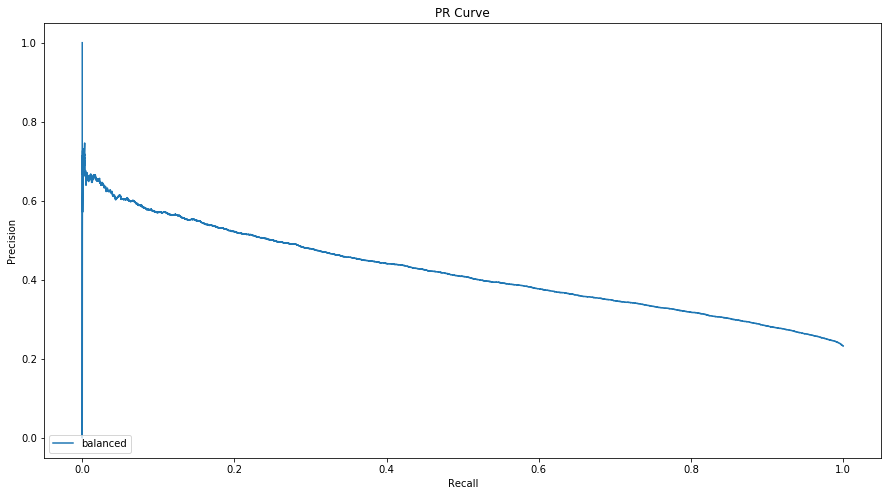

In [187]:
b_pprob = lr_model.predict_proba(X_valid)[:,1]
b_pre, b_rec, b_thrs = precision_recall_curve(y_valid,b_pprob)

# check Precision Recall plot
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,1,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')
# ax1.plot(unb_rec, unb_pre, label='unbalanced')
ax1.plot(b_rec, b_pre, label='balanced')
ax1.legend(loc='lower left')
plt.show()

In [191]:
# save model for scoring
from joblib import dump
mpath = os.path.join(ppath, 'models', 'logistic_regr')
dump(lr_model, os.path.join(mpath, 'logistic_regr.joblib'))

['/home/justin/projects/lendingclub/models/logistic_regr.joblib']

In [198]:
# save necessities for scoring
dump(all_train_colnames.to_list(), os.path.join(mpath,'all_train_colnames.joblib'))
dump(max_dict, os.path.join(mpath,'max_dict.joblib'))
dump(min_dict, os.path.join(mpath,'min_dict.joblib'))
dump(new_null_colnames, os.path.join(mpath,'new_null_colnames.joblib'))
dump(fill_dict, os.path.join(mpath,'fill_dict.joblib'))
dump(cats_dict, os.path.join(mpath,'cats_dict.joblib'))
dump(norm_dict, os.path.join(mpath,'norm_dict.joblib'))

['/home/justin/projects/lendingclub/models/norm_dict.joblib']

# Old

# Fastai style dataprep

In [47]:
lr_model = LogisticRegression(class_weight='balanced')
lr_model.fit(X_train, y_train['target_strict'])
pred = lr_model.predict(X_valid)

/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


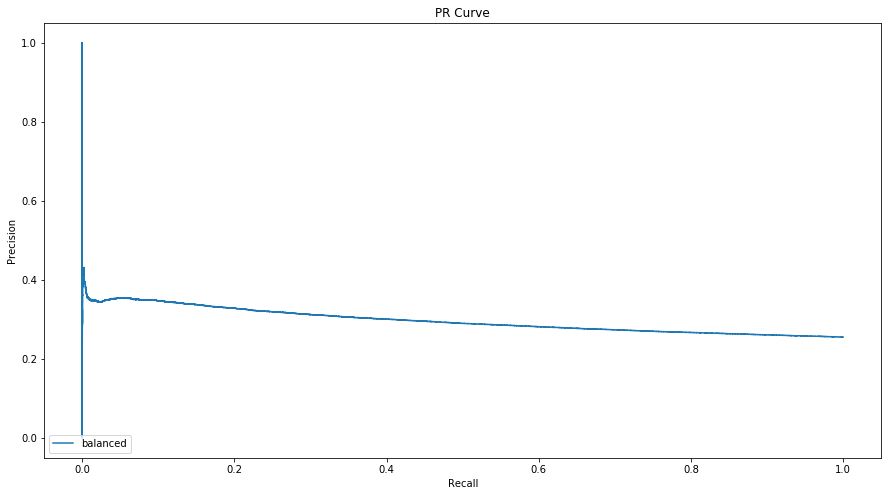

In [49]:
b_pprob = lr_model.predict_proba(X_valid)[:,1]
b_pre, b_rec, b_thrs = precision_recall_curve(y_valid['target_strict'],b_pprob)

# check Precision Recall plot
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,1,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')
# ax1.plot(unb_rec, unb_pre, label='unbalanced')
ax1.plot(b_rec, b_pre, label='balanced')
ax1.legend(loc='lower left')
plt.show()

# Old

In [25]:
# lr_model = LogisticRegression()
# lr_model.fit(X_train, y_train)
# pred = lr_model.predict(X_test)

In [27]:
# %matplotlib inline
# from mpl_toolkits.mplot3d import Axes3D

/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


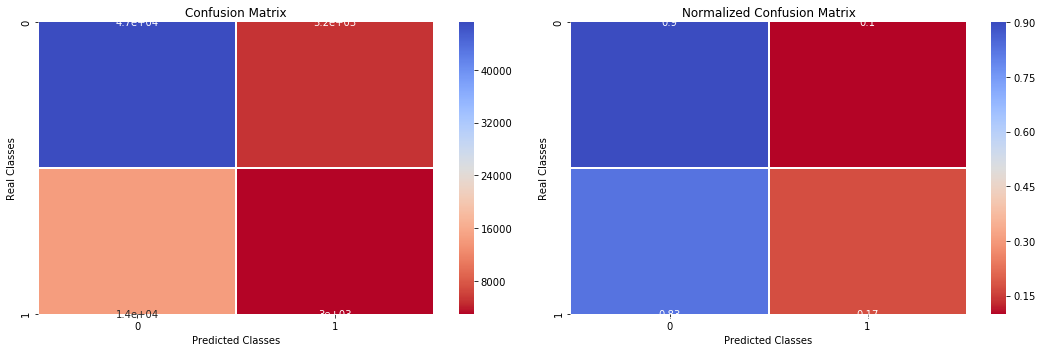

---Classification Report---
              precision    recall  f1-score   support

           0       0.77      0.90      0.83     52407
           1       0.37      0.17      0.23     17461

    accuracy                           0.72     69868
   macro avg       0.57      0.54      0.53     69868
weighted avg       0.67      0.72      0.68     69868



In [28]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
pred = lr_model.predict(X_test)
PlotConfusionMatrix(y_test,pred,y_test_non_def,y_test_def)

/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


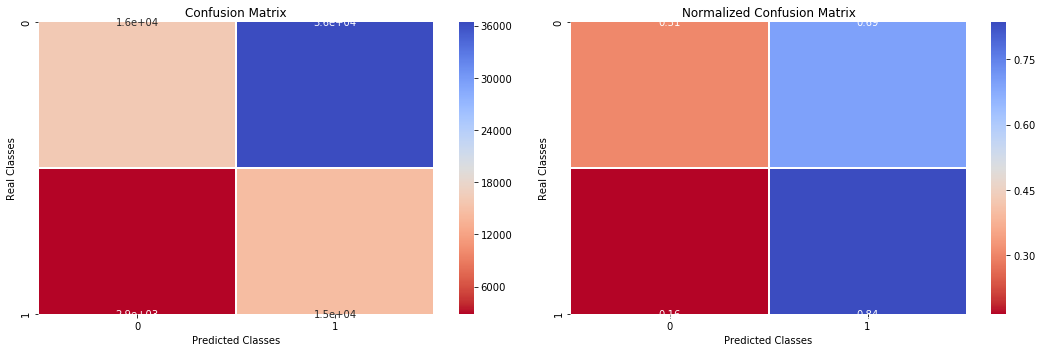

---Classification Report---
              precision    recall  f1-score   support

           0       0.85      0.31      0.45     52407
           1       0.29      0.84      0.43     17461

    accuracy                           0.44     69868
   macro avg       0.57      0.57      0.44     69868
weighted avg       0.71      0.44      0.44     69868



In [29]:
lr_model = LogisticRegression(class_weight='balanced')
lr_model.fit(X_train, y_train)
pred = lr_model.predict(X_test)
PlotConfusionMatrix(y_test,pred,y_test_non_def,y_test_def)

---Weight of 1 for Default class---


/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


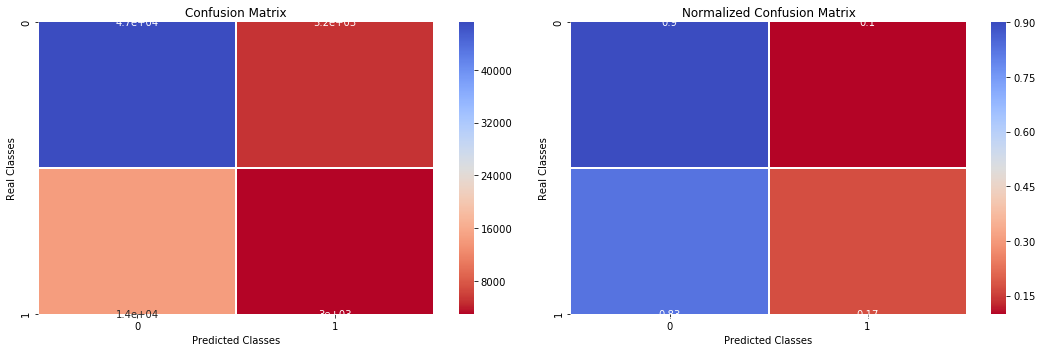

---Classification Report---
              precision    recall  f1-score   support

           0       0.77      0.90      0.83     52407
           1       0.37      0.17      0.23     17461

    accuracy                           0.72     69868
   macro avg       0.57      0.54      0.53     69868
weighted avg       0.67      0.72      0.68     69868

---Weight of 5 for Default class---


/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


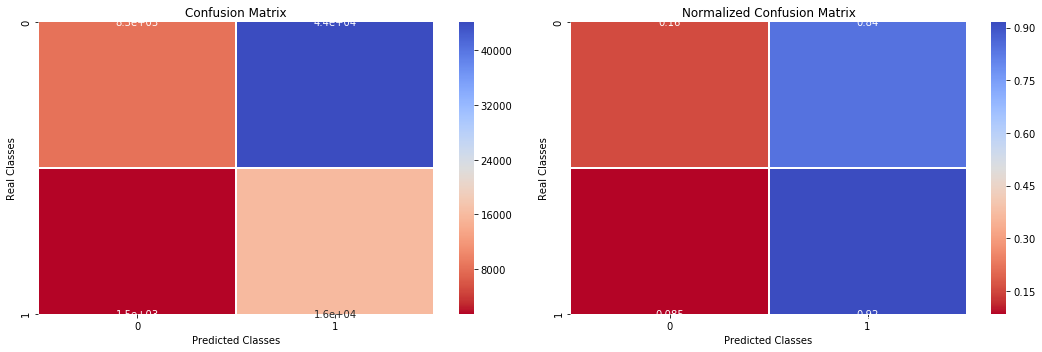

---Classification Report---
              precision    recall  f1-score   support

           0       0.85      0.16      0.27     52407
           1       0.27      0.92      0.41     17461

    accuracy                           0.35     69868
   macro avg       0.56      0.54      0.34     69868
weighted avg       0.70      0.35      0.30     69868

---Weight of 10 for Default class---


/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


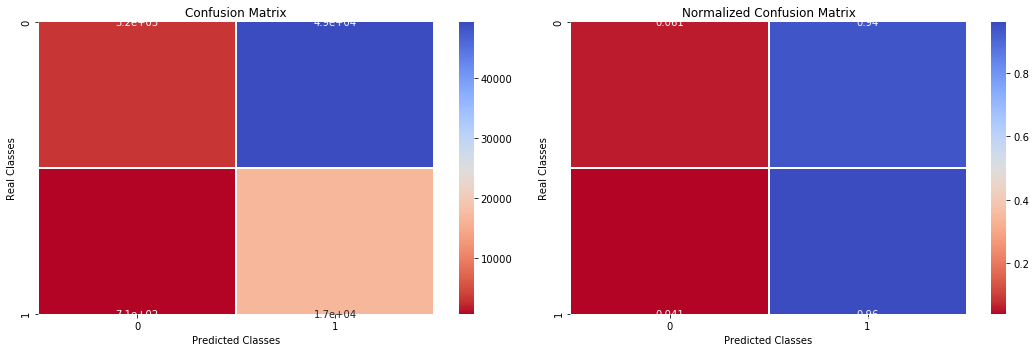

---Classification Report---
              precision    recall  f1-score   support

           0       0.82      0.06      0.11     52407
           1       0.25      0.96      0.40     17461

    accuracy                           0.29     69868
   macro avg       0.54      0.51      0.26     69868
weighted avg       0.68      0.29      0.19     69868

---Weight of 100 for Default class---


/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


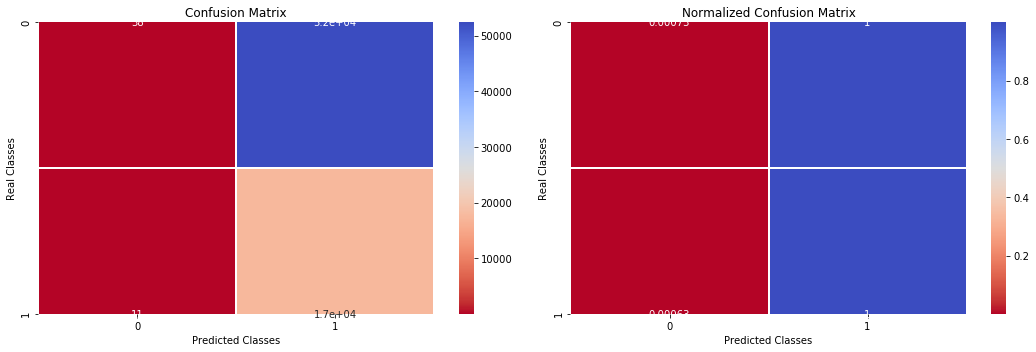

---Classification Report---
              precision    recall  f1-score   support

           0       0.78      0.00      0.00     52407
           1       0.25      1.00      0.40     17461

    accuracy                           0.25     69868
   macro avg       0.51      0.50      0.20     69868
weighted avg       0.64      0.25      0.10     69868

---Weight of 500 for Default class---


/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


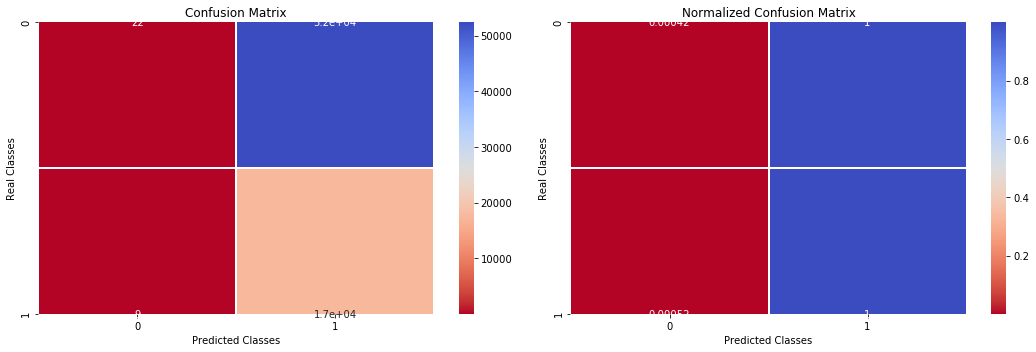

---Classification Report---
              precision    recall  f1-score   support

           0       0.71      0.00      0.00     52407
           1       0.25      1.00      0.40     17461

    accuracy                           0.25     69868
   macro avg       0.48      0.50      0.20     69868
weighted avg       0.59      0.25      0.10     69868

---Weight of 1000 for Default class---


/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


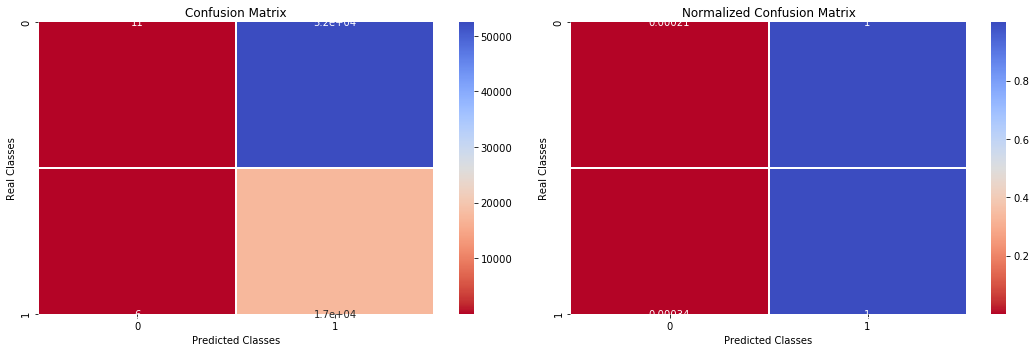

---Classification Report---
              precision    recall  f1-score   support

           0       0.65      0.00      0.00     52407
           1       0.25      1.00      0.40     17461

    accuracy                           0.25     69868
   macro avg       0.45      0.50      0.20     69868
weighted avg       0.55      0.25      0.10     69868



In [30]:
for w in [1,5,10,100,500,1000]:
    print('---Weight of {} for Default class---'.format(w))
    lr_model = LogisticRegression(class_weight={0:1,1:w})
    lr_model.fit(X_train, y_train)
    pred = lr_model.predict(X_test)
    PlotConfusionMatrix(y_test,pred,y_test_non_def,y_test_def)

/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


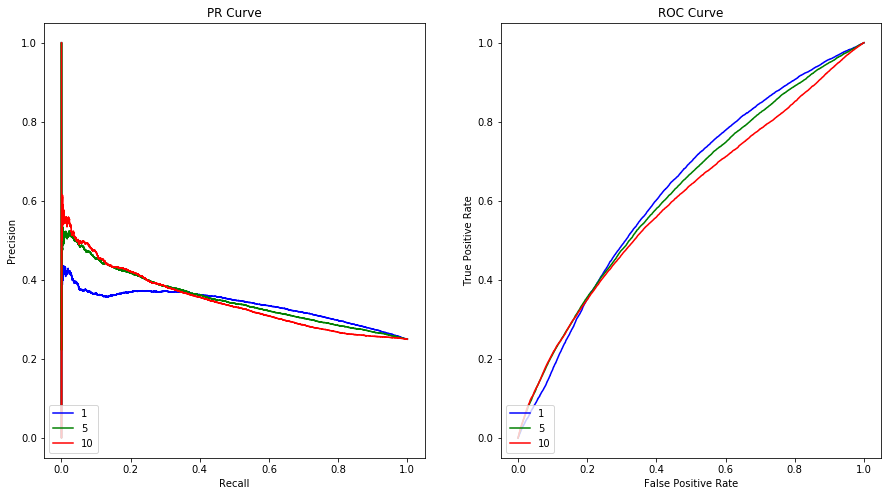

In [36]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

prob_dicts = {}
for w,k in zip([1,5,10],'bgr'):#,20,50,100,10000, cmykw
    lr_model = LogisticRegression(class_weight={0:1,1:w})
    lr_model.fit(X_train,y_train)
    pred_prob = lr_model.predict_proba(X_test)[:,1]

    p,r,probs = precision_recall_curve(y_test,pred_prob)
    prob_dicts[w] = (p, r, probs)
    tpr,fpr,_ = roc_curve(y_test,pred_prob)
    
    ax1.plot(r,p,c=k,label=w)
    ax2.plot(tpr,fpr,c=k,label=w)
ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')

plt.show()

In [35]:
prob_dicts[10]

array([8.85419242e-04, 8.97956606e-04, 9.02321896e-04, ...,
       9.61388462e-01, 9.70093860e-01, 9.77186561e-01])

In [32]:
classification_report??

In [33]:
precision_recall_curve??